In [2]:
import pathlib
import seaborn as sns
import utils
import pandas as pd
import requests
import numpy as np

url = 'https://glusfqycvwrucp9-db202202211424.adb.eu-zurich-1.oraclecloudapps.com/ords/sensor_datalake1/sens/insert/'

page_result = utils.get_all_pages(url)

df = utils.to_data_frame(page_result)


In [3]:
df.head()

,entry_id,insert_time,sensor_id,value1,unit1
0,2150.0,2022-03-24T14:28:41.709Z,CIRCUITPY323d,661.6,PPM
1,2158.0,2022-03-24T14:29:29.060Z,CIRCUITPY323d,28.1,%
2,2168.0,2022-03-24T14:30:57.714Z,CIRCUITPY323d,839.6,PPM
3,2185.0,2022-03-24T14:32:53.229Z,CIRCUITPY323d,30.5,%
4,2188.0,2022-03-24T14:33:15.675Z,CIRCUITPY323d,30.6,%


In [4]:

#convert inser_time to timedate
df['insert_time'] = pd.to_datetime(df['insert_time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   entry_id     914 non-null    float64            
 1   insert_time  914 non-null    datetime64[ns, UTC]
 2   sensor_id    914 non-null    object             
 3   value1       914 non-null    float64            
 4   unit1        914 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 35.8+ KB


In [59]:
#pivot
df_pivot = df.pivot_table(index='insert_time',columns=['sensor_id','unit1'],values='value1')
#multindex to single index
df_pivot.columns =	df_pivot.columns.map('_'.join)
#resample on 5min time windows

df_pivot = df_pivot.resample('1Min').agg({'CIRCUITPY323d_PPM':'mean','CIRCUITPY323d_C':'mean','CIRCUITPY323d_%':'mean','CIRCUITPY825a_Window':'last','RASPBERRYPEOPLE_People':'last'})
df_pivot.head(30)


,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,RASPBERRYPEOPLE_People
insert_time,,,,,
2022-03-24 14:02:00+00:00,1068.800000,26.600000,34.600000,0.0,NaN
2022-03-24 14:03:00+00:00,1073.700000,26.500000,32.500000,NaN,3.0
2022-03-24 14:04:00+00:00,1061.600000,26.400000,33.450000,NaN,NaN
2022-03-24 14:05:00+00:00,1072.400000,26.400000,33.950000,NaN,NaN
2022-03-24 14:06:00+00:00,1115.650000,26.400000,34.150000,NaN,NaN
2022-03-24 14:07:00+00:00,1145.600000,26.400000,34.700000,NaN,NaN
2022-03-24 14:08:00+00:00,1142.450000,26.400000,35.000000,NaN,NaN
2022-03-24 14:09:00+00:00,1152.500000,26.400000,35.550000,NaN,NaN
2022-03-24 14:10:00+00:00,1200.900000,26.400000,35.850000,NaN,NaN


In [76]:
#Fill Nan for window sensor
df_pivot['CIRCUITPY825a_Window'].fillna(method='ffill',inplace=True)
#Fill Nan for people sensor
df_pivot['RASPBERRYPEOPLE_People'].fillna(method='ffill',inplace=True)
#Fill Nan for first entry for people sensor
df_pivot['RASPBERRYPEOPLE_People'].fillna(method='bfill',inplace=True)

df_pivot.head(30)

,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,RASPBERRYPEOPLE_People
insert_time,,,,,
2022-03-24 14:02:00+00:00,1068.800000,26.600000,34.600000,0.0,3.0
2022-03-24 14:03:00+00:00,1073.700000,26.500000,32.500000,0.0,3.0
2022-03-24 14:04:00+00:00,1061.600000,26.400000,33.450000,0.0,3.0
2022-03-24 14:05:00+00:00,1072.400000,26.400000,33.950000,0.0,3.0
2022-03-24 14:06:00+00:00,1115.650000,26.400000,34.150000,0.0,3.0
2022-03-24 14:07:00+00:00,1145.600000,26.400000,34.700000,0.0,3.0
2022-03-24 14:08:00+00:00,1142.450000,26.400000,35.000000,0.0,3.0
2022-03-24 14:09:00+00:00,1152.500000,26.400000,35.550000,0.0,3.0
2022-03-24 14:10:00+00:00,1200.900000,26.400000,35.850000,0.0,3.0


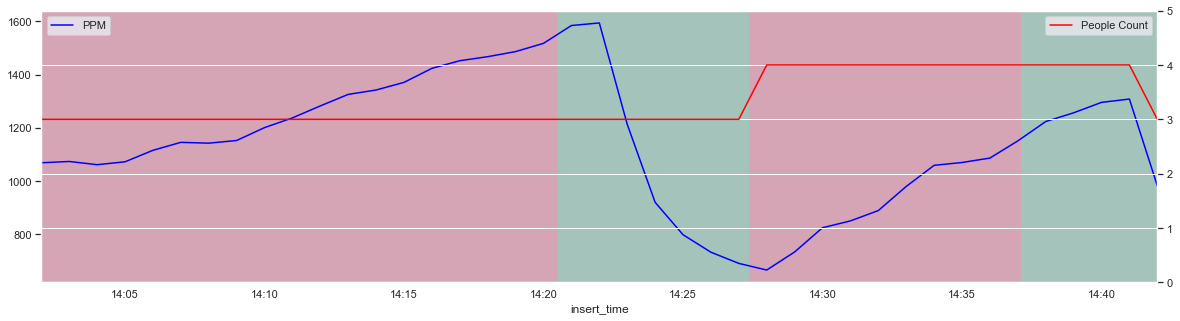

In [100]:
#linechart cobined with bar chart
#if windows sensor 1 blue line if windows sensor 0 red line
# Use a boundary norm instead
fig, ax1 = plt.subplots()
#hide grid
ax1 = df_pivot['CIRCUITPY323d_PPM'].plot(kind='line',color='blue',label='PPM', grid=False)
ax2 = ax1.twinx()
ax2 = df_pivot['RASPBERRYPEOPLE_People'].plot(kind='line',color='red',label='People Count',ylim=(0,5))
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),df_pivot['CIRCUITPY825a_Window'].values[np.newaxis],cmap='RdYlGn', alpha=0.3,label='Windows')
#set size
ax1.figure.set_size_inches(20, 5)
#show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
#additonal legend for window sensor


plt.show()